# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import os
import shutil
import seaborn as sns
import torch
import torchvision.transforms as transforms
import csv
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from tqdm.auto import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR

In [ ]:
drive.mount('/content/drive', force_remount=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cpu


In [ ]:
!unzip "/content/drive/My Drive/50.039_Deep_Learning/dataset_120_square.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_120_square/44261_left.jpeg  
  inflating: /content/dataset_120_square/44261_right.jpeg  
  inflating: /content/dataset_120_square/44262_left.jpeg  
  inflating: /content/dataset_120_square/44262_right.jpeg  
  inflating: /content/dataset_120_square/44263_left.jpeg  
  inflating: /content/dataset_120_square/44263_right.jpeg  
  inflating: /content/dataset_120_square/44264_left.jpeg  
  inflating: /content/dataset_120_square/44264_right.jpeg  
  inflating: /content/dataset_120_square/44265_left.jpeg  
  inflating: /content/dataset_120_square/44265_right.jpeg  
  inflating: /content/dataset_120_square/44267_left.jpeg  
  inflating: /content/dataset_120_square/44267_right.jpeg  
  inflating: /content/dataset_120_square/44268_left.jpeg  
  inflating: /content/dataset_120_square/44268_right.jpeg  
  inflating: /content/dataset_120_square/44275_left.jpeg  
  inflating: /content/dataset_120_square/44275_right.jpeg

In [ ]:
root_path = '/content/drive/MyDrive/50.039_Deep_Learning/'
new_folder_path = '/content/dataset_120_square'
folder_path = root_path + 'dataset_120_square'
csv_path = root_path + 'trainLabels.csv'
# os.chdir(root_path)
print(os.getcwd())

/content


In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df['side'] = df['image'].str.split('_').str[1]
df

,image,level,side
0,10_left,0,left
1,10_right,0,right
2,13_left,0,left
3,13_right,0,right
4,15_left,1,left
...,...,...,...
35121,44347_right,0,right
35122,44348_left,0,left
35123,44348_right,0,right
35124,44349_left,0,left


In [ ]:
# Split the DataFrame into train and temp sets (80% train, 10% Validation, 10% Test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_df))
print("Validation set size:", len(validation_df))
print("Test set size:", len(test_df))

Train set size: 28100
Validation set size: 3513
Test set size: 3513


In [ ]:
train_df

,image,level,side
27260,34494_left,0,left
29485,37332_right,4,right
26867,33978_right,0,right
25385,32104_right,0,right
21643,27261_right,0,right
...,...,...,...
16850,21127_left,0,left
6265,7880_right,2,right
11284,14169_left,0,left
860,1042_left,0,left


In [ ]:
class EyeImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.transform = transforms.ToTensor()
        self.errCounter = 0

    def __len__(self):
        return len(self.dataframe)

    def processcondition(self, severity, side):
       condition = str(severity) + str(side)
       switch = {
          "0right": 0,
          "1right":1,
          "2right":2,
          "3right":3,
          "4right":4,
          "0left":5,
          "1left":6,
          "2left":7,
          "3left":8,
          "4left":9,
       }
       out = switch.get(condition, "nothing")
       return out

    def __getitem__(self, idx):
        img_filename = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        severity = self.dataframe.iloc[idx,1]
        side = self.dataframe.iloc[idx,2]
        try:
          image = Image.open(img_filename+".jpeg").convert("RGB")
          image_tensor = self.transform(image)
          image_tensor = image_tensor.to(device)

          condition = torch.tensor(self.processcondition(severity,side)).to(device)
          return image_tensor, condition
        except FileNotFoundError:
          self.errCounter += 1
          print("File not found")

          return torch.zeros([3, 120, 120]), torch.zeros([0])

train_dataset = EyeImageDataset(dataframe=train_df, image_dir=new_folder_path)
validation_dataset = EyeImageDataset(dataframe=validation_df, image_dir=new_folder_path)
test_dataset = EyeImageDataset(dataframe=test_df, image_dir=new_folder_path)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Generator and Discriminator Models

## Linear Models

In [ ]:
## BASE NETWORK
# 40x60
# 60x60
# 60x40
# 40x20
# 20ximg_shape
class Base_CGAN_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape): # (n_channels, height, width)
        super(Base_CGAN_Generator, self).__init__()
        self.img_shape = img_shape
        self.label_emb = nn.Embedding(n_classes, embedding_dim)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + embedding_dim, latent_dim * 3, normalize=False),
            *block(latent_dim * 3, latent_dim * 3),
            *block(latent_dim * 3, latent_dim * 2),
            *block(latent_dim * 2, latent_dim * 1),
            nn.Linear(latent_dim * 1, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((self.label_emb(labels), z), -1)
        img = self.model(gen_input)
        img = img.view(img.shape[0], * self.img_shape)
        return img

class Base_CGAN_Discriminator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape):
        super(Base_CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim + int(np.prod(img_shape)), latent_dim * 3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(latent_dim * 3, latent_dim * 3),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(latent_dim * 3, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
### WIDE NETWORK
# 40x64
# 64x128
# 128x128
# 128x256
# 256x128
# 128x64
# 64ximg

class Wide_CGAN_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape): # (n_channels, height, width)
        super(Wide_CGAN_Generator, self).__init__()
        self.img_shape = img_shape
        self.label_emb = nn.Embedding(n_classes, embedding_dim)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + embedding_dim, 2**6, normalize=False),
            *block(2**6, 2**7),
            *block(2**7, 2**7),
            *block(2**7, 2**8),
            *block(2**8, 2**7),
            *block(2**7, 2**6),
            nn.Linear(2**6 , int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((self.label_emb(labels), z), -1)
        img = self.model(gen_input)
        img = img.view(img.shape[0], * self.img_shape)
        return img

class Wide_CGAN_Discriminator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape):
        super(Wide_CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim + int(np.prod(img_shape)), 2**6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**6, 2**6),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**6, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
### NARROW NETWORK
# 40x256
# 256x128
# 128x128
# 128x64
# 64x16
# 16x4
# 4ximg_shape
class Narrow_CGAN_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape): # (n_channels, height, width)
        super(Narrow_CGAN_Generator, self).__init__()
        self.img_shape = img_shape
        self.label_emb = nn.Embedding(n_classes, embedding_dim)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + embedding_dim, 2**8, normalize=False),
            *block(2**8, 2**7),
            *block(2**7, 2**7),
            *block(2**7, 2**6),
            *block(2**6, 2**4),
            *block(2**4, 2**2),
            nn.Linear(2**2 , int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat((self.label_emb(labels), z), -1)
        img = self.model(gen_input)
        img = img.view(img.shape[0], * self.img_shape)
        return img

class Narrow_CGAN_Discriminator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape):
        super(Narrow_CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim + int(np.prod(img_shape)), 2**8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**8, 2**4),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2**4, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

## Convolutional Models

In [ ]:
class Conv_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim=40, embedding_dim=20, img_shape=None):
        super(Conv_Generator, self).__init__()
        d = 100
        self.label_emb = nn.Embedding(n_classes, embedding_dim)
        self.deconv1_1 = nn.ConvTranspose2d(in_channels=latent_dim, out_channels=latent_dim,kernel_size=1,stride= 1,padding= 0)
        self.deconv1_1_bn = nn.BatchNorm2d(latent_dim)
        self.deconv1_2 = nn.ConvTranspose2d(embedding_dim, embedding_dim, 5, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(embedding_dim)
        self.deconv2 = nn.ConvTranspose2d(latent_dim+embedding_dim, d*4, 11, 1, 0)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 18, 1, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def forward(self, input, label):
        input = torch.randn(input.shape[0], input.shape[1], 5, 5, device=device)
        x = F.leaky_relu(self.deconv1_1_bn(self.deconv1_1(input)), 0.2)
        b = self.label_emb(label)
        b = b.unsqueeze(-1).unsqueeze(-1).to(device)
        y = F.leaky_relu(self.deconv1_2_bn(self.deconv1_2(b)), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = F.tanh(self.deconv5(x))
        return x

In [ ]:
class WConv_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, embedding_dim, img_shape): # (n_channels, height, width)
        super(WConv_Generator, self).__init__()
        self.img_shape = img_shape
        self.label_emb = nn.Embedding(n_classes, embedding_dim)

        def convblock(in_feat, out_feat, kernel_size=4, stride=2, padding=1, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, kernel_size=kernel_size, stride=stride, padding=padding)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.condLayer = nn.Sequential(
            *convblock(embedding_dim, embedding_dim, 3, 3, 0),
            *convblock(embedding_dim, embedding_dim, 5, 5, 0)
          )

        self.model = nn.Sequential(
            *convblock(latent_dim + embedding_dim, latent_dim * 3),
            *convblock(latent_dim * 3, latent_dim * 2),
            *convblock(latent_dim * 2, 3),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = Tensor(np.random.normal(0, 1, (z.shape[0], z.shape[1], 15, 15))).to(device)
        cond_input = self.label_emb(labels).unsqueeze(-1).unsqueeze(-1) # (b, emb_size, 1, 1)
        cond_input = self.condLayer(cond_input)
        gen_input = torch.cat((cond_input, z), 1)
        img = self.model(gen_input)
        return img

# Loss, Accuracy, Train function

In [ ]:
Tensor = torch.cuda.FloatTensor if device == "cuda" else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if device == "cuda" else torch.LongTensor

In [ ]:
def calculate_accuracy(pred_tensor, actual_tensor):
    pred_tensor = torch.sigmoid(pred_tensor)
    pred_tensor = torch.round(pred_tensor)
    # Convert tensors to numpy arrays (16,1) shape for both
    pred_array = pred_tensor.cpu().detach().numpy().flatten()  # Assuming tensors are on CPU
    actual_array = actual_tensor.cpu().detach().numpy().flatten()
    # Calculate accuracy
    correct = (pred_array == actual_array).sum()
    total = len(pred_array)
    accuracy = correct / total
    return accuracy

# Example usage
pred_values = torch.tensor([ 7.7389407, 5.366177, 9.258968, 5.6526093, 10.611077, 7.5793633, 5.0778985, 18.754156, 3.9165132, 3.511753, 1.9574507, 11.225401, 4.268784, 8.758661, 5.640184, 5.4411726])
actual_values = torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

accuracy = calculate_accuracy(pred_values, actual_values)
print("Accuracy:", accuracy)

def write_list_to_csv(data_list, file_path):
    with open(file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for row in data_list:
            writer.writerow([row])

Accuracy: 1.0


In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP.
       Warning: It doesn't compute the gradient w.r.t the labels, only w.r.t
       the interpolated real and fake samples, as in the WGAN GP paper.
    """
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    labels = labels.type(LongTensor).to(device)
    # Get random interpolation between real and fake samples

    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0).to(device)
    fake.requires_grad = False
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

In [ ]:
def wasserstein_loss( discriminator, real_imgs_d, fake_imgs_d,
                        conditions_d, real_validity, fake_validity):
    # Gradient penalty
    lambda_gp = 10
    gradient_penalty = compute_gradient_penalty(
                        discriminator, real_imgs_d, fake_imgs_d,
                        conditions_d)
    return -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

In [ ]:
def cg_loss(fake_validity, y_fake, real_validity, y_real):
  loss_fn = nn.BCEWithLogitsLoss()

  dfake_loss = loss_fn(fake_validity, y_fake)
  dreal_loss = loss_fn(real_validity, y_real)
  d_loss = dfake_loss + dreal_loss
  return d_loss

In [ ]:
latent_dim = 20
n_classes = 10 # Severity, side
embedding_dim = 20
height = 120
width = 120
img_shape = (3, height, width)
lambda_gp = 10
num_epochs = 30
n_critic = 5

In [ ]:
def train(folder_path, loss, generator, discriminator, optimizer_G, optimizer_D):#, schedulerG, schedulerD):
  generator.train()
  loss_fn = nn.BCEWithLogitsLoss()

  disc_history = []
  gen_history = []
  disc_racc = []
  disc_facc = []
  g_acc = []

  batches_done = 0
  # Training loop
  for epoch in range(num_epochs):
      pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
      for i, (real_images, conditions) in enumerate(train_dataloader):
          for d in discriminator.parameters():
            d.requires_grad = True

          discriminator.zero_grad()
          batch_size = real_images.shape[0]

          real_imgs = real_images.type(Tensor).to(device)
          conditions = conditions.type(LongTensor).to(device)

          # ---------------------
          #  Train Discriminator
          # ---------------------

          optimizer_D.zero_grad()

          z = Tensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
          fake_imgs = generator(z, conditions).to(device)

          # Real and fake images
          real_validity = discriminator(real_imgs, conditions)
          fake_validity = discriminator(fake_imgs, conditions)

          y_real = torch.ones(batch_size).unsqueeze(-1).to(device)
          y_fake = torch.zeros(batch_size).unsqueeze(-1).to(device)

          disc_accr = calculate_accuracy(real_validity, y_real)
          disc_accf = calculate_accuracy(fake_validity, y_fake)
          disc_racc.append(disc_accr)
          disc_facc.append(disc_accf)

          # Adversarial loss
          if loss == "wgan":
            d_loss = wasserstein_loss(discriminator, real_imgs.data, fake_imgs.data,
                            conditions.data, real_validity, fake_validity)
          if loss == "cgan":
            # d_loss = cg_loss(fake_validity, y_fake, real_validity, y_real)
            dfake_loss = loss_fn(fake_validity, y_fake)
            dreal_loss = loss_fn(real_validity, y_real)
            d_loss = dfake_loss + dreal_loss

          d_loss.backward()
          optimizer_D.step()

          optimizer_G.zero_grad()

          # Train the generator every n_critic steps
          if i % n_critic == 0:

              for d in discriminator.parameters():
                d.requires_grad = False
              generator.zero_grad()
              # -----------------
              #  Train Generator
              # -----------------

              fake_imgs = generator(z, conditions)
              # Train on fake images
              fake_validity = discriminator(fake_imgs, conditions)
              y_real = torch.ones(batch_size).unsqueeze(-1).to(device)

              g_accg = calculate_accuracy(fake_validity, y_real)
              g_acc.append(g_accg)

              # Adversarial loss
              if loss == "wgan":
                g_loss = -torch.mean(fake_validity)
              if loss == "cgan":
                g_loss = loss_fn(fake_validity, y_real)

              g_loss.backward()
              optimizer_G.step()

              pbar.set_description("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [R acc: %g] [F acc: %g] [G acc: %g]"
                % (epoch+1, num_epochs, i, len(train_dataloader), d_loss.item(), g_loss.item(), disc_accr, disc_accf, g_accg))

              disc_history.append(f"{d_loss.item():.4f}")
              gen_history.append(f"{g_loss.item():.4f}")

              batches_done += n_critic

          pbar.update(1)

      pbar.close()
      # schedulerG.step()
      # schedulerD.step()
      if (epoch+1) % 10 == 0:
        torch.save(generator.state_dict(), folder_path+f"generator_1_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), folder_path+f"discriminator_1_{epoch+1}.pth")
  write_list_to_csv(disc_racc, folder_path+f"discRacc_1_30e.csv")
  write_list_to_csv(disc_facc, folder_path+f"discFacc_1_30e.csv")
  write_list_to_csv(g_acc, folder_path+f"Gacc_1_30e.csv")
  write_list_to_csv(disc_history, folder_path+f"discloss_1_30e.csv")
  write_list_to_csv(gen_history, folder_path+f"genloss_1_30e.csv")

# cGAN

Base Network

In [ ]:
generator = Base_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Base_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 / (10 * (epoch+1 / 30)) if epoch <= 30 else 0.0002
# Define the scheduler
# schedulerG = LambdaLR(optimizer_G, lr_lambda=lambda_lr)
# schedulerD = LambdaLR(optimizer_D, lr_lambda=lambda_lr)

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'cgan_lin/120/base/'
train(cgan_folder_path , "cgan", generator, discriminator, optimizer_G, optimizer_D)

Wide Network

In [ ]:
generator = Wide_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Wide_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 * (0.1 ** (epoch // 30))
# Define the scheduler
# scheduler = LambdaLR(optimizer_G, lr_lambda=lambda_lr)
# scheduler = LambdaLR(optimizer_D, lr_lambda=lambda_lr)

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'cgan_lin/120/mid'
train(cgan_folder_path , "cgan", generator, discriminator, optimizer_G, optimizer_D)

Narrow Network

In [ ]:
generator = Narrow_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Narrow_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 * (0.1 ** (epoch // 30))

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'cgan_lin/120/deep'
train(cgan_folder_path , "cgan", generator, discriminator, optimizer_G, optimizer_D)

# WGAN

Base Network

In [ ]:
generator = Base_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Base_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.0002 # * (0.1 * (epoch / 30)) if epoch <= 30 else 0.0002
# Define the scheduler
# schedulerG = LambdaLR(optimizer_G, lr_lambda=lambda_lr)
# schedulerD = LambdaLR(optimizer_D, lr_lambda=lambda_lr)

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'wgan/120/base/'
train(cgan_folder_path , "wgan", generator, discriminator, optimizer_G, optimizer_D)

Wide Network

In [ ]:
generator = Wide_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Wide_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/mid/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/mid/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 * (0.1 ** (epoch // 30))

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'wgan/120/mid/'
train(cgan_folder_path , "wgan", generator, discriminator, optimizer_G, optimizer_D)

Narrow Network

In [ ]:
generator = Narrow_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Narrow_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 * (0.1 ** (epoch // 30))

disc_history = []
gen_history = []

In [ ]:
cgan_folder_path = root_path + 'wgan/120/deep/'
train(cgan_folder_path , "wgan", generator, discriminator, optimizer_G, optimizer_D)

# cWCGAN

In [ ]:
generator = WConv_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Narrow_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/generator_1_30.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/120/base/120e_3/discriminator_1_30.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.002 / (10 * (epoch+1 / 30)) if epoch <= 30 else 0.0002
# Define the scheduler
# schedulerG = LambdaLR(optimizer_G, lr_lambda=lambda_lr)
# schedulerD = LambdaLR(optimizer_D, lr_lambda=lambda_lr)

disc_history = []
gen_history = []

In [ ]:
generator.load_state_dict(torch.load(root_path + "cwcgan/30e/generator_1_30.pth"))
discriminator.load_state_dict(torch.load(root_path + "cwcgan/30e/discriminator_1_30.pth"))

<All keys matched successfully>

In [ ]:
cwcgan_folder_path = root_path + 'cwcgan/'
train(cwcgan_folder_path , "wgan", generator, discriminator, optimizer_G, optimizer_D)

# cCGAN

In [ ]:
generator = Conv_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)
discriminator = Narrow_CGAN_Discriminator(n_classes, latent_dim, embedding_dim, img_shape).to(device)

# generator.load_state_dict(torch.load(root_path + "wgan/middeep_net/generator_480.pth"))
# discriminator.load_state_dict(torch.load(root_path + "wgan/middeep_net/discriminator_480.pth"))

# Set optimizer for each network
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the lambda function for the scheduler
lambda_lr = lambda epoch: 0.0002 # * (0.1 * (epoch / 30)) if epoch <= 30 else 0.0002
# Define the scheduler
# schedulerG = LambdaLR(optimizer_G, lr_lambda=lambda_lr)
# schedulerD = LambdaLR(optimizer_D, lr_lambda=lambda_lr)

disc_history = []
gen_history = []

In [ ]:
ccgan_folder_path = root_path + 'ccgan/'
train(ccgan_folder_path , "cgan", generator, discriminator, optimizer_G, optimizer_D)

# Inference

In [ ]:
def get_images_with_condition(dataset, condition):
    images = []
    for idx in range(len(dataset)):
        image, current_condition = dataset[idx]
        if current_condition.item() == condition.item():
            images.append(image)
            if len(images) == 16:
                break
    images_tensor = torch.stack(images)
    return images_tensor

def processcondition(severity, side):
       condition = str(severity) + str(side)
       switch = {
          "0right": 0,
          "1right":1,
          "2right":2,
          "3right":3,
          "4right":4,
          "0left":5,
          "1left":6,
          "2left":7,
          "3left":8,
          "4left":9,
       }
       out = switch.get(condition, "nothing")
       out = torch.tensor(out).to(device)
       out = out.repeat(16, 1)
       out = out.squeeze()
       #print(out.shape)
       return out

def plot_imgs(generator, severity=4, side="right"):
  condition = processcondition(severity, side).to(device)
  real_imgs = get_images_with_condition(train_dataset, condition[0].squeeze())
  real_imgs = real_imgs.cpu()

  generator.eval()
  with torch.no_grad():
      z = Tensor(np.random.normal(0, 1, (16, latent_dim))).to(device)
      fake_imgs = generator(z, condition)
  fake_imgs = fake_imgs.cpu()

  fig, axs = plt.subplots(4, 4, figsize=(16, 16))

  for i in range(16):
      row = i // 4
      col = i % 4
      image = fake_imgs[i].permute(1, 2, 0).numpy()
      axs[row, col].imshow(image)
      axs[row, col].axis('off')
  plt.show()

  fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
  sns.distplot(real_imgs.cpu(), label='Real Images', hist=True, color='#fc0328', ax=axs)
  sns.distplot(fake_imgs.cpu(), label='Generated Images', hist=True, color='#0c06c7', ax=axs)
  axs.legend(loc='upper right', prop={'size': 12})
  plt.show()

model_dict = {
    "cGAN Base": ["cgan_lin/120/base/", Base_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cGAN Wide": ["cgan_lin/120/mid/", Wide_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cGAN Narrow": ["cgan_lin/120/deep/", Narrow_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cWGAN Base": ["wgan/120/base/", Base_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cWGAN Wide": ["wgan/120/mid/", Wide_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cWGAN Narrow": ["wgan/120/deep/", Narrow_CGAN_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cWCGAN": ["cwcgan/", WConv_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)],
    "cCGAN": ["ccgan/", Conv_Generator(n_classes, latent_dim, embedding_dim, img_shape).to(device)]
}

def plot_rimgs(severity=4, side="right"):
  condition = processcondition(severity, side).to(device)
  real_imgs = get_images_with_condition(train_dataset, condition[0].squeeze())
  real_imgs = real_imgs.cpu()

  fig, axs = plt.subplots(4, 4, figsize=(16, 16))

  for i in range(16):
      row = i // 4
      col = i % 4
      image = real_imgs[i].permute(1, 2, 0).numpy()
      axs[row, col].imshow(image)
      axs[row, col].axis('off')
  plt.show()

In [ ]:
def display_all(severity, side):
  for model in model_dict:
    print(model)
    location = model_dict[model][0]
    generator = model_dict[model][1]
    print(model + " 30e")
    generator.load_state_dict(torch.load(root_path + location + "30e/generator_1_30.pth", map_location=device))
    plot_imgs(generator, severity, side)
    print(model + " 60e")
    generator.load_state_dict(torch.load(root_path + location + "60e/generator_1_30.pth", map_location=device))
    plot_imgs(generator, severity, side)
    print(model + " 90e")
    generator.load_state_dict(torch.load(root_path + location + "90e/generator_1_30.pth", map_location=device))
    plot_imgs(generator, severity, side)

In [ ]:
display_all(0, "right")

In [ ]:
display_all(4, "left")

In [ ]:
display_all(0, "left")

In [ ]:
plot_imgs(generator)

In [ ]:
model = "cWGAN Wide"
location = model_dict[model][0]
generator = model_dict[model][1]
print(model + " 210e_3")
generator.load_state_dict(torch.load(root_path + location + "210e_3/generator_1_30.pth", map_location=device))
print("0r")
plot_rimgs(0, "right")
plot_imgs(generator, 0, "right")
# print("1r")
# # plot_rimgs(1, "right")
# plot_imgs(generator, 1, "right")
# print("2r")
# # plot_rimgs(2, "right")
# plot_imgs(generator, 2, "right")
# print("3r")
# # plot_rimgs(3, "right")
# plot_imgs(generator, 3, "right")
# print("4r")
# # plot_rimgs(4, "right")
# plot_imgs(generator, 4, "right")

# print("0l")
# plot_imgs(generator, 0, "left")
# print("1l")
# plot_imgs(generator, 1, "left")
# print("2l")
# plot_imgs(generator, 2, "left")
# print("3l")
# plot_imgs(generator, 3, "left")
# print("4l")
# plot_imgs(generator, 4, "left")

# Losses and Accuracy


In [ ]:
def read_result_csv(folder_path_30, folder_path_60, folder_path_90):
  # File paths
  discF_acc1 = pd.read_csv(root_path + folder_path_30 + "discFacc_1_30e.csv")
  discF_acc2 = pd.read_csv(root_path + folder_path_60 + "discFacc_1_30e.csv")
  discF_acc3 = pd.read_csv(root_path + folder_path_90 + "discFacc_1_30e.csv")

  discR_acc1 = pd.read_csv(root_path + folder_path_30 + "discRacc_1_30e.csv")
  discR_acc2 = pd.read_csv(root_path + folder_path_60 + "discRacc_1_30e.csv")
  discR_acc3 = pd.read_csv(root_path + folder_path_90 + "discRacc_1_30e.csv")

  disc_loss1 = pd.read_csv(root_path + folder_path_30 + "discloss_1_30e.csv")
  disc_loss2 = pd.read_csv(root_path + folder_path_60 + "discloss_1_30e.csv")
  disc_loss3 = pd.read_csv(root_path + folder_path_90 + "discloss_1_30e.csv")

  gen_loss1 = pd.read_csv(root_path + folder_path_30 + "genloss_1_30e.csv")
  gen_loss2 = pd.read_csv(root_path + folder_path_60 + "genloss_1_30e.csv")
  gen_loss3 = pd.read_csv(root_path + folder_path_90 + "genloss_1_30e.csv")

  gen_acc1 = pd.read_csv(root_path + folder_path_30 + "Gacc_1_30e.csv")
  gen_acc2 = pd.read_csv(root_path + folder_path_60 + "Gacc_1_30e.csv")
  gen_acc3 = pd.read_csv(root_path + folder_path_90 + "Gacc_1_30e.csv")

  # List to hold DataFrames
  disc_F = []
  for df in [discF_acc1,discF_acc2,discF_acc3]:
      disc_F.append(df.iloc[:, 0])  # Assuming the column you want is the second column, change index accordingly
  # Concatenate the DataFrames along the rows
  D_accF = pd.concat(disc_F, axis=0, ignore_index=True)

  # List to hold DataFrames
  disc_R = []
  for df in [discR_acc1,discR_acc2,discR_acc3]:
      disc_R.append(df.iloc[:, 0])  # Assuming the column you want is the second column, change index accordingly
  # Concatenate the DataFrames along the rows
  D_accR = pd.concat(disc_R, axis=0, ignore_index=True)

  # List to hold DataFrames
  disc_losses = []
  for df in [disc_loss1,disc_loss2,disc_loss3]:
      disc_losses.append(df.iloc[:, 0])  # Assuming the column you want is the second column, change index accordingly
  # Concatenate the DataFrames along the rows
  D_loss = pd.concat(disc_losses, axis=0, ignore_index=True)

  # List to hold DataFrames
  gen_losses = []
  for df in [gen_loss1,gen_loss2,gen_loss3]:
      gen_losses.append(df.iloc[:, 0])  # Assuming the column you want is the second column, change index accordingly
  # Concatenate the DataFrames along the rows
  G_loss = pd.concat(gen_losses, axis=0, ignore_index=True)

  # List to hold DataFrames
  gen_acc = []
  for df in [gen_acc1,gen_acc2,gen_acc3]:
      gen_acc.append(df.iloc[:, 0])  # Assuming the column you want is the second column, change index accordingly
  # Concatenate the DataFrames along the rows
  G_acc = pd.concat(gen_acc, axis=0, ignore_index=True)

  return D_accF, D_accR, D_loss, G_loss, G_acc



In [ ]:
def further_train_csv(folder_path_120):
  # File paths
  D_accF = pd.read_csv(root_path + folder_path_120 + "discFacc_1_30e.csv").iloc[:,0]
  D_accR = pd.read_csv(root_path + folder_path_120 + "discRacc_1_30e.csv").iloc[:,0]
  D_loss = pd.read_csv(root_path + folder_path_120 + "discloss_1_30e.csv").iloc[:,0]
  G_loss = pd.read_csv(root_path + folder_path_120 + "genloss_1_30e.csv").iloc[:,0]
  G_acc = pd.read_csv(root_path + folder_path_120 + "Gacc_1_30e.csv").iloc[:,0]
  return D_accF, D_accR, D_loss, G_loss, G_acc

In [ ]:
def plot_acc(D_accF, D_accR , G_acc, msg):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot for discF_acc
    axs[0].scatter(D_accF.index, D_accF)
    axs[0].set_title('Discriminator Fake Accuracy '+ msg)
    mean_value = D_accF.mean()
    std_val = D_accF.std()
    median_value = D_accF.median()
    axs[0].axhline(y=mean_value, color='r', linestyle='-', label='Mean: {:.2f}'.format(mean_value))
    axs[0].axhline(y=median_value, color='g', linestyle='-', label='Median: {:.2f}'.format(median_value))
    axs[0].axhline(y=mean_value + std_val , color='b', linestyle='--', label='Mean + Std: {:.2f}'.format(mean_value + std_val))
    axs[0].axhline(y=mean_value - std_val, color='b', linestyle='--', label='Mean - Std: {:.2f}'.format(mean_value - std_val))
    axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    print(f"Mean: {mean_value}. Median: {median_value}. Mean + std = {mean_value+std_val}. Mean - std = {mean_value-std_val}")

    # Plot for discR_acc
    axs[1].scatter(D_accR.index, D_accR)
    axs[1].set_title(' Discriminator Real Accuracy '+ msg)
    mean_value = D_accR.mean()
    std_val = D_accR.std()
    median_value = D_accR.median()
    axs[1].axhline(y=mean_value, color='r', linestyle='-', label='Mean: {:.2f}'.format(mean_value))
    axs[1].axhline(y=median_value, color='g', linestyle='-', label='Median: {:.2f}'.format(median_value))
    axs[1].axhline(y=mean_value + std_val , color='b', linestyle='--', label='Mean + Std: {:.2f}'.format(mean_value + std_val))
    axs[1].axhline(y=mean_value - std_val, color='b', linestyle='--', label='Mean - Std: {:.2f}'.format(mean_value - std_val))
    axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    print(f"Mean: {mean_value}. Median: {median_value}. Mean + std = {mean_value+std_val}. Mean - std = {mean_value-std_val}")


    # Plot for gen_acc
    axs[2].scatter(G_acc.index, G_acc)
    axs[2].set_title('Generator Accuracy '+ msg)
    mean_value = G_acc.mean()
    std_val = G_acc.std()
    median_value = G_acc.median()
    axs[2].axhline(y=mean_value, color='r', linestyle='-', label='Mean: {:.2f}'.format(mean_value))
    axs[2].axhline(y=median_value, color='g', linestyle='-', label='Median: {:.2f}'.format(median_value))
    axs[2].axhline(y=mean_value + std_val , color='b', linestyle='--', label='Mean + Std: {:.2f}'.format(mean_value + std_val))
    axs[2].axhline(y=mean_value - std_val, color='b', linestyle='--', label='Mean - Std: {:.2f}'.format(mean_value - std_val))
    axs[2].legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    print(f"Mean: {mean_value}. Median: {median_value}. Mean + std = {mean_value+std_val}. Mean - std = {mean_value-std_val}")

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()



In [ ]:
def plot_loss(D_loss, G_loss, msg):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot for discR_acc
    axs[0].plot(D_loss.index, D_loss)
    axs[0].set_title('Discriminator Loss' + msg)
    mean_value = D_loss.mean()
    std_val = D_loss.std()
    median_value = D_loss.median()
    axs[0].axhline(y=mean_value, color='r', linestyle='-', label='Mean: {:.2f}'.format(mean_value))
    axs[0].axhline(y=median_value, color='g', linestyle='-', label='Median: {:.2f}'.format(median_value))
    axs[0].axhline(y=mean_value + std_val , color='b', linestyle='--', label='Mean + Std: {:.2f}'.format(mean_value + std_val))
    axs[0].axhline(y=mean_value - std_val, color='b', linestyle='--', label='Mean - Std: {:.2f}'.format(mean_value - std_val))
    axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    print(f"Mean: {mean_value}. Median: {median_value}. Mean + std = {mean_value+std_val}. Mean - std = {mean_value-std_val}")

    # Plot for gen_acc
    axs[1].plot(G_loss.index, G_loss)
    axs[1].set_title('Generator Loss'+ msg)
    mean_value = G_loss.mean()
    std_val = G_loss.std()
    median_value = G_loss.median()
    axs[1].axhline(y=mean_value, color='r', linestyle='-', label='Mean: {:.2f}'.format(mean_value))
    axs[1].axhline(y=median_value, color='g', linestyle='-', label='Median: {:.2f}'.format(median_value))
    axs[1].axhline(y=mean_value + std_val , color='b', linestyle='--', label='Mean + Std: {:.2f}'.format(mean_value + std_val))
    axs[1].axhline(y=mean_value - std_val, color='b', linestyle='--', label='Mean - Std: {:.2f}'.format(mean_value - std_val))
    axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=2)
    print(f"Mean: {mean_value}. Median: {median_value}. Mean + std = {mean_value+std_val}. Mean - std = {mean_value-std_val}")

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()

## cGAN Base

Mean: 0.9647083515149215. Median: 1.0. Mean + std = 1.0430150566816. Mean - std = 0.8864016463482429
Mean: 0.9202863837295339. Median: 0.9375. Mean + std = 1.0030926665192685. Mean - std = 0.8374801009397991
Mean: 0.02235454746345929. Median: 0.0. Mean + std = 0.07687902931354443. Mean - std = -0.032169934386625854


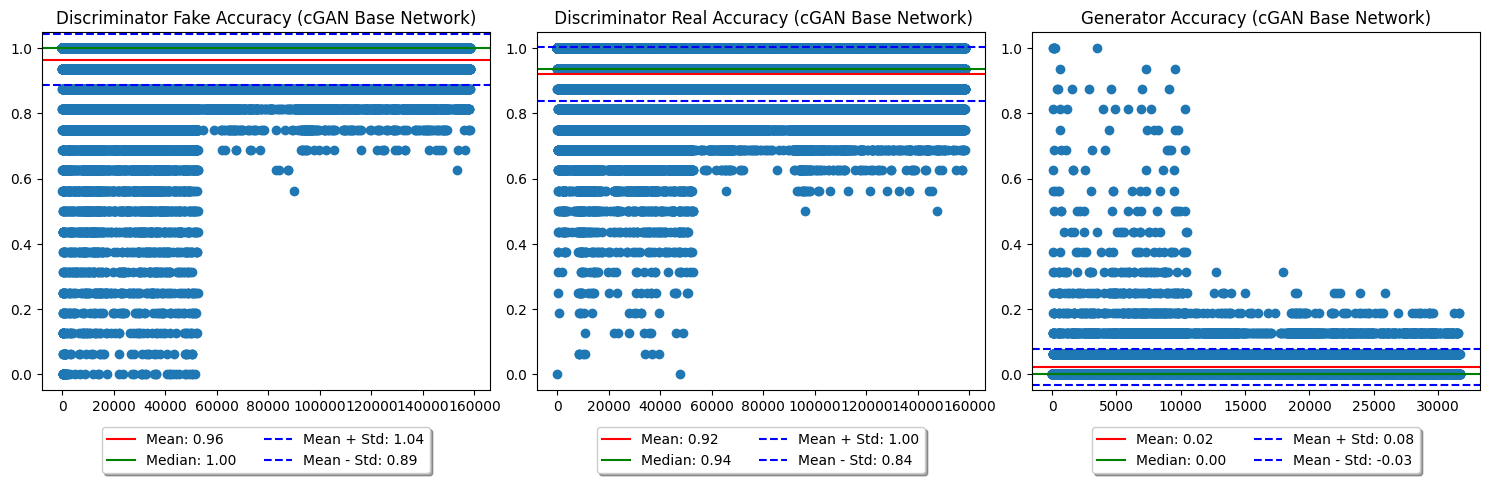

Mean: 0.2936584682892951. Median: 0.234. Mean + std = 0.591461861366297. Mean - std = -0.0041449247877068385
Mean: 4.090785222716798. Median: 3.8406. Mean + std = 5.964609318048591. Mean - std = 2.2169611273850047


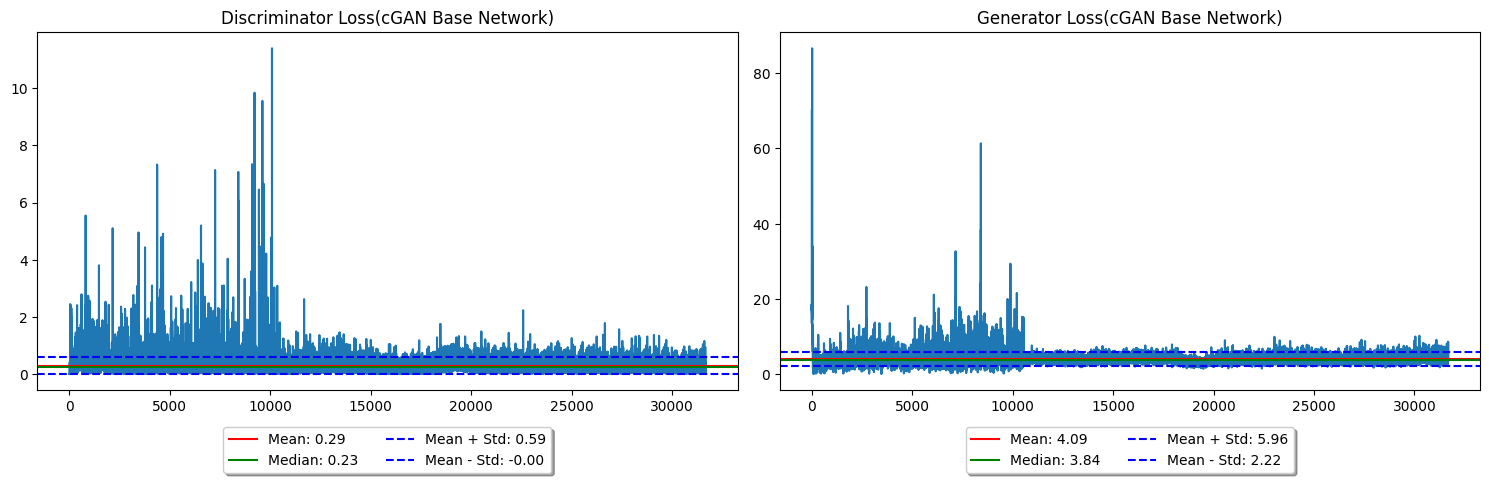

In [ ]:
fp_30 = "cgan_lin/120/base/30e/"
fp_60 = "cgan_lin/120/base/60e/"
fp_90 = "cgan_lin/120/base/90e/"
msg = "(cGAN Base Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cGAN Wide

Mean: 0.933422581216364. Median: 1.0. Mean + std = 1.0693146592418552. Mean - std = 0.7975305031908728
Mean: 0.9427117917876138. Median: 1.0. Mean + std = 1.0555001990456951. Mean - std = 0.8299233845295324
Mean: 0.03663344066672981. Median: 0.0. Mean + std = 0.12223074514224089. Mean - std = -0.04896386380878127


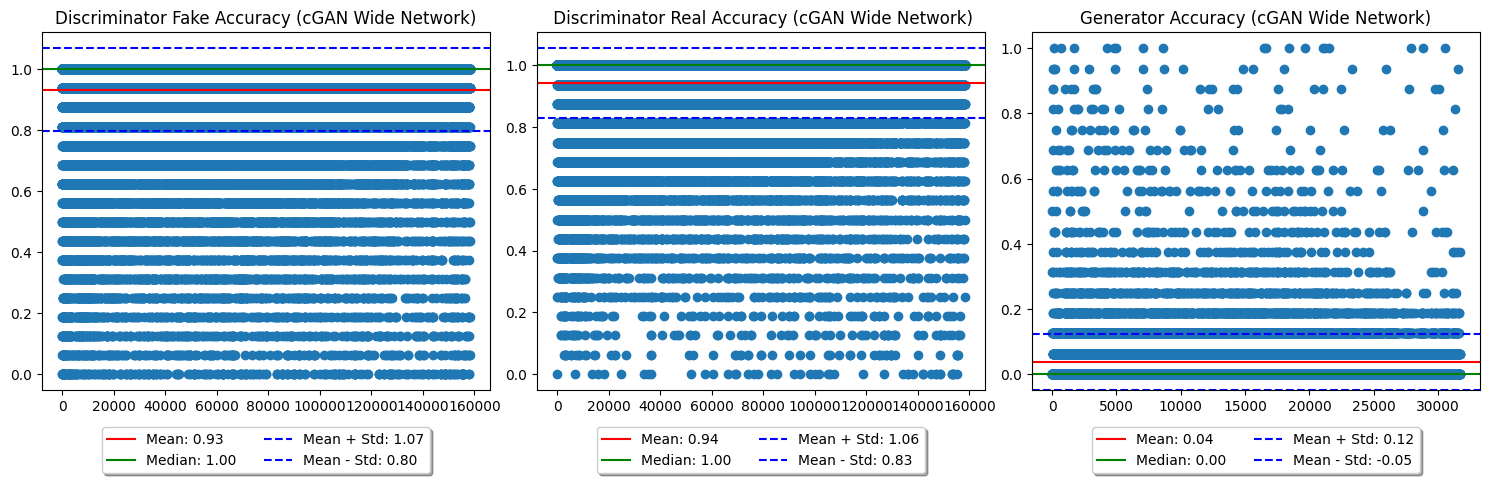

Mean: 0.2831500173627553. Median: 0.111. Mean + std = 1.0271955678331448. Mean - std = -0.46089553310763426
Mean: 27.43155229030527. Median: 17.4741. Mean + std = 61.96683656080611. Mean - std = -7.103731980195569


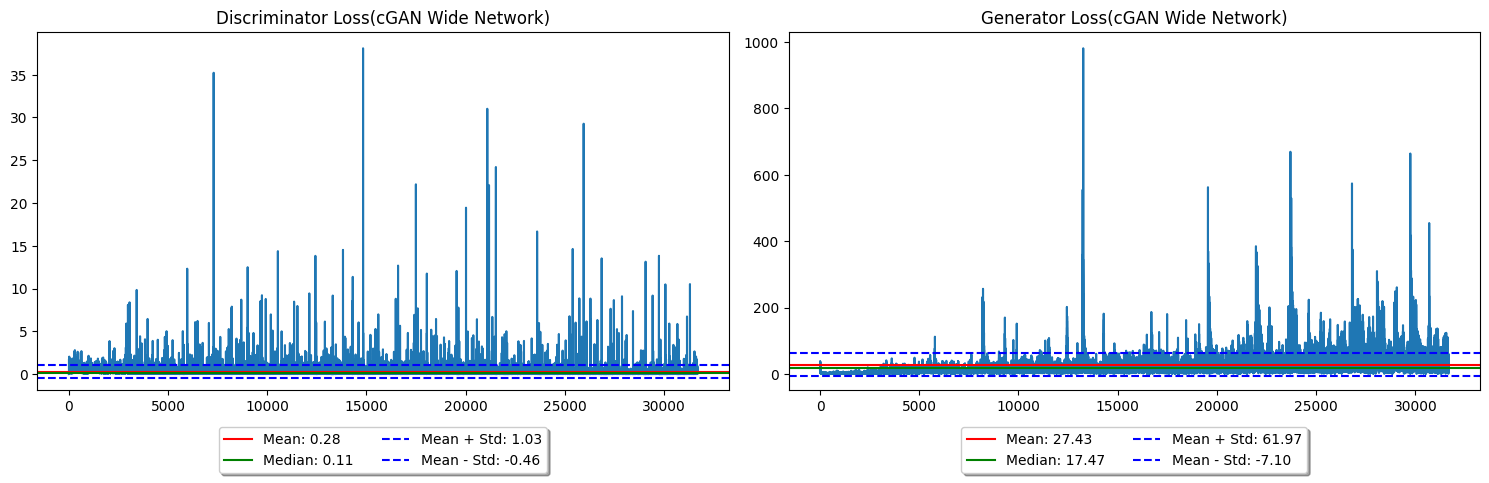

In [ ]:
fp_30 = "cgan_lin/120/mid/30e/"
fp_60 = "cgan_lin/120/mid/60e/"
fp_90 = "cgan_lin/120/mid/90e/"
msg = "(cGAN Wide Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cGAN Narrow

Mean: 0.9942953290709367. Median: 1.0. Mean + std = 1.041858749549239. Mean - std = 0.9467319085926343
Mean: 0.992836454242476. Median: 1.0. Mean + std = 1.0198458672155994. Mean - std = 0.9658270412693526
Mean: 0.0048773558102093. Median: 0.0. Mean + std = 0.049685463114758785. Mean - std = -0.03993075149434018


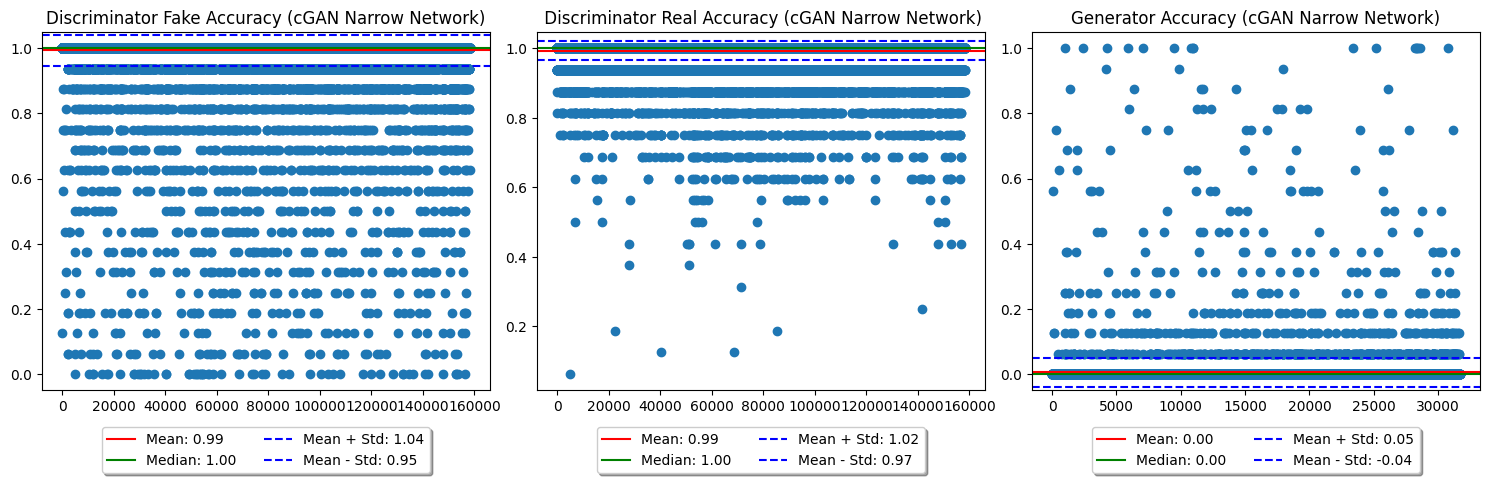

Mean: 0.18771295892919151. Median: 0.0005. Mean + std = 2.373952316415685. Mean - std = -1.9985263985573019
Mean: 22.75300213088361. Median: 14.1107. Mean + std = 50.46394160289677. Mean - std = -4.957937341129547


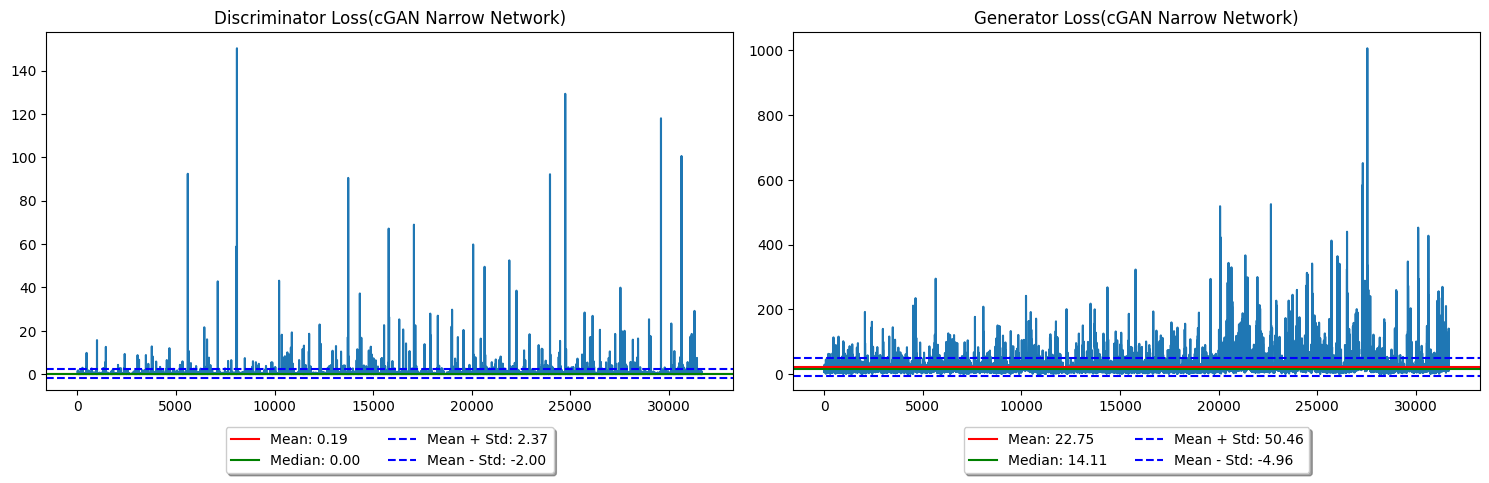

In [ ]:
fp_30 = "cgan_lin/120/deep/30e/"
fp_60 = "cgan_lin/120/deep/60e/"
fp_90 = "cgan_lin/120/deep/90e/"
msg = "(cGAN Narrow Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cWGAN Base

Mean: 0.4974739449935811. Median: 0.5. Mean + std = 0.710499224539804. Mean - std = 0.28444866544735825
Mean: 0.5253392051958236. Median: 0.5. Mean + std = 0.7419646132591111. Mean - std = 0.308713797132536
Mean: 0.5007832970293904. Median: 0.5. Mean + std = 0.714409468613112. Mean - std = 0.28715712544566874


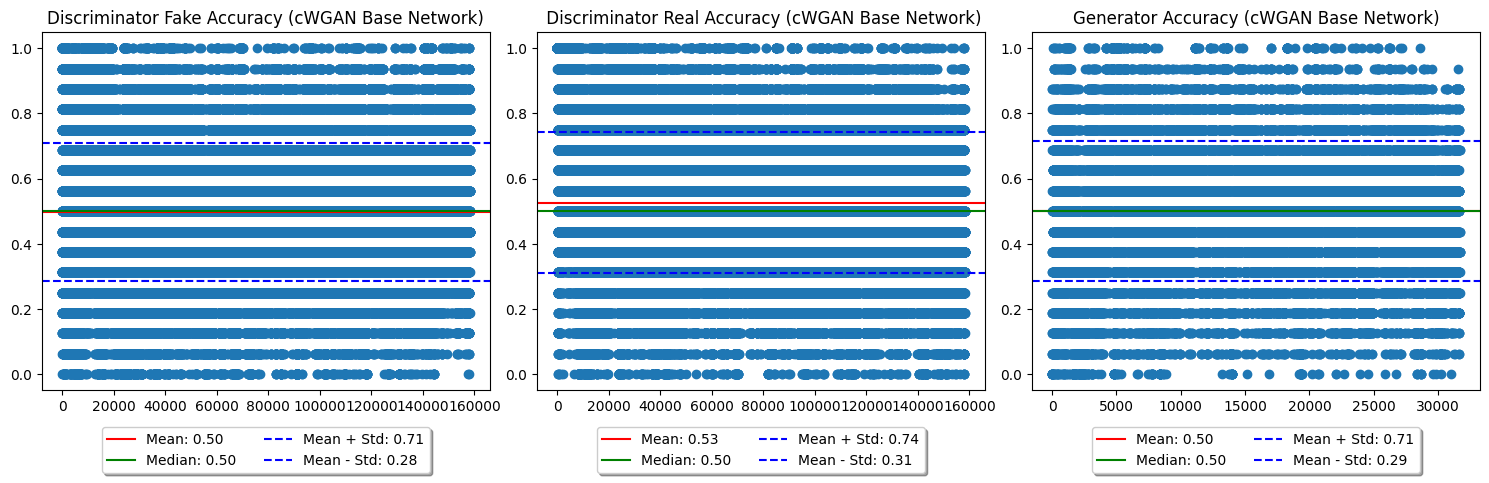

Mean: 0.6825962654291755. Median: -1.1007. Mean + std = 74.22703305275638. Mean - std = -72.86184052189805
Mean: -0.02575759699466581. Median: -0.1914. Mean + std = 90.4174127736877. Mean - std = -90.46892796767703


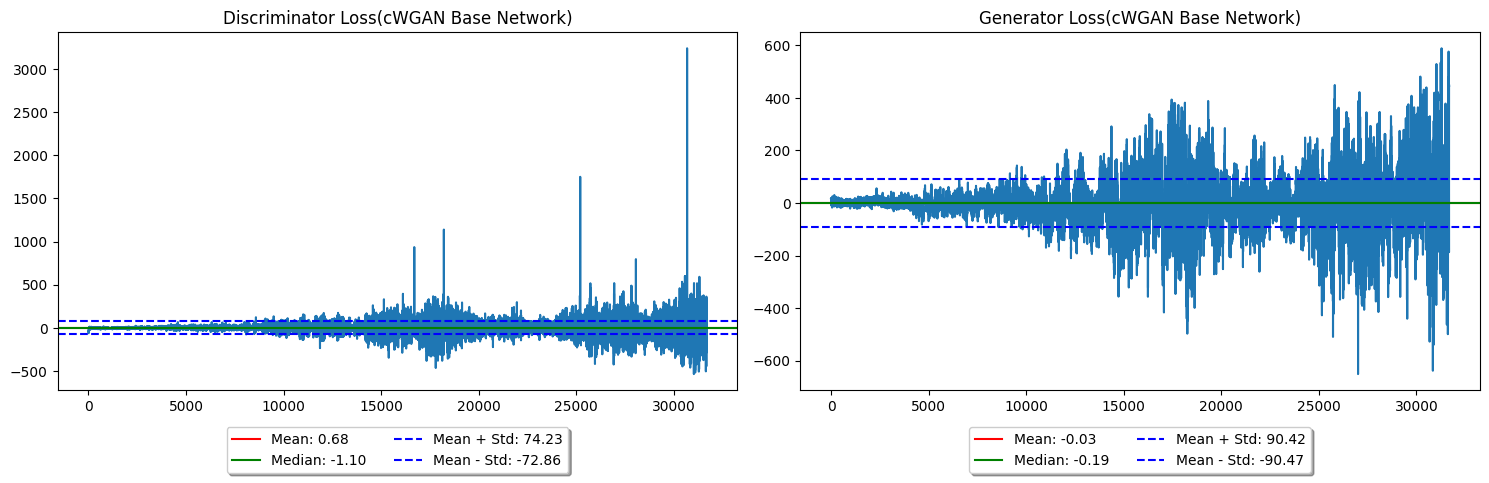

In [ ]:
fp_30 = "wgan/120/base/30e/"
fp_60 = "wgan/120/base/60e/"
fp_90 = "wgan/120/base/90e/"
msg = "(cWGAN Base Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cWGAN Wide

Mean: 0.42469660462792563. Median: 0.4375. Mean + std = 0.636450157295753. Mean - std = 0.21294305196009822
Mean: 0.588792948073384. Median: 0.625. Mean + std = 0.7984079136455653. Mean - std = 0.3791779825012027
Mean: 0.5736910850143637. Median: 0.5625. Mean + std = 0.7853944973433018. Mean - std = 0.36198767268542564


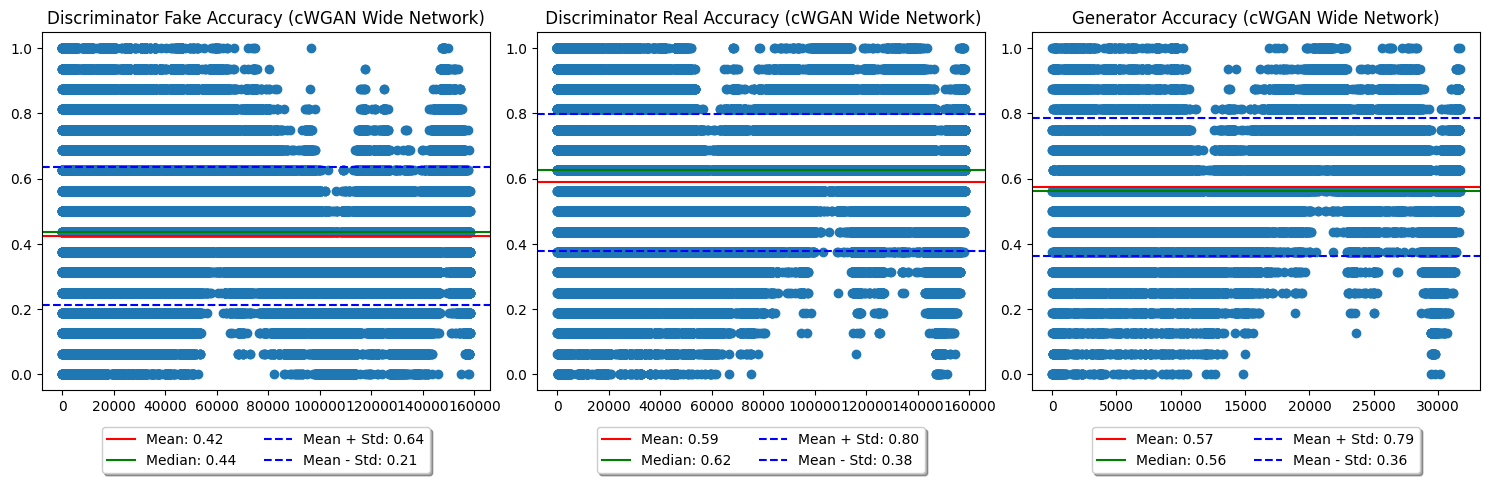

Mean: -0.2607746661615684. Median: -0.0921. Mean + std = 17.07214471272349. Mean - std = -17.59369404504663
Mean: -9.288448899832687. Median: -8.0515. Mean + std = 15.953222887969751. Mean - std = -34.530120687635126


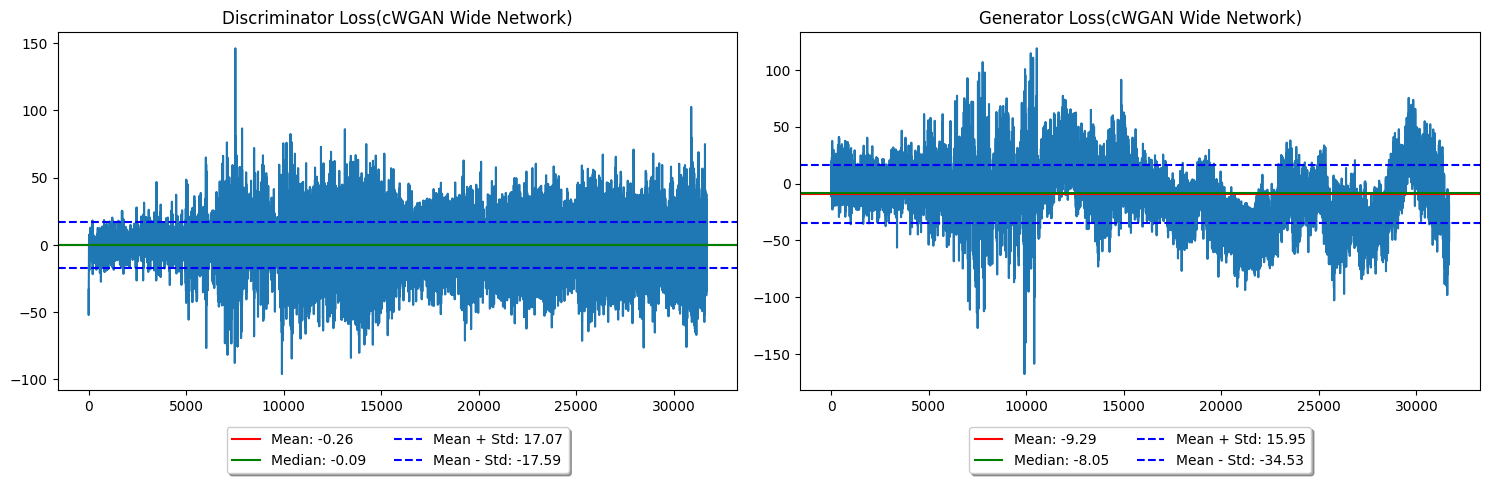

In [ ]:
fp_30 = "wgan/120/mid/30ee/"
fp_60 = "wgan/120/mid/60ee/"
fp_90 = "wgan/120/mid/90ee/"
msg = "(cWGAN Wide Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

Mean: 0.37004591246276725. Median: 0.375. Mean + std = 0.582655455222927. Mean - std = 0.15743636970260744
Mean: 0.632860374888539. Median: 0.625. Mean + std = 0.845714560661829. Mean - std = 0.4200061891152489
Mean: 0.6294797770066557. Median: 0.625. Mean + std = 0.8419724605910528. Mean - std = 0.41698709342225854


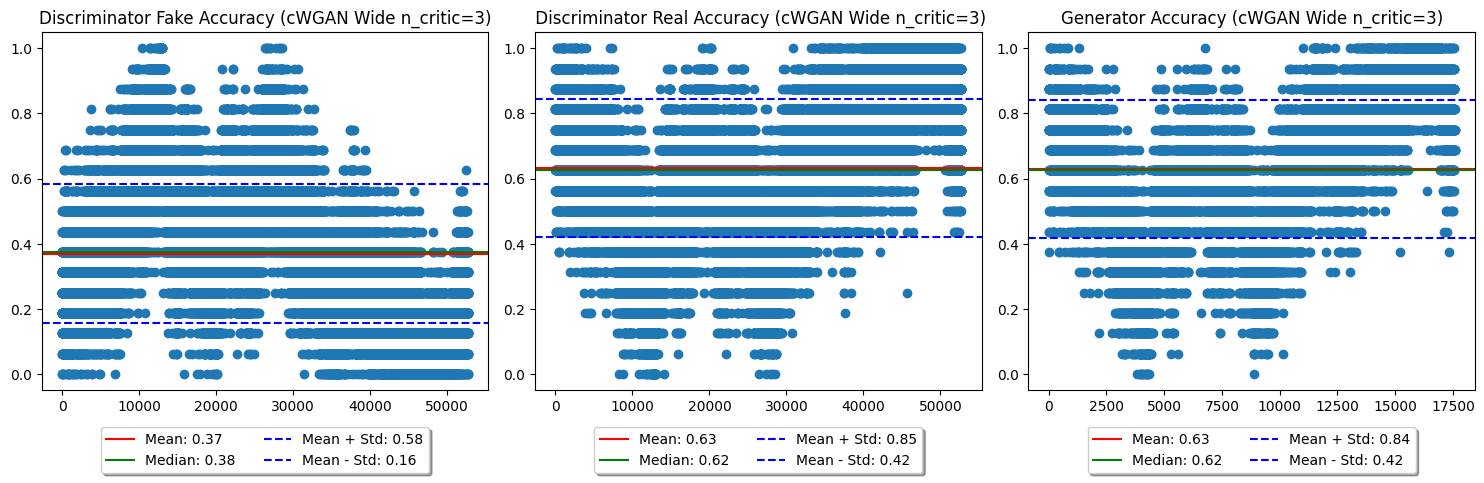

Mean: 0.0656619432277149. Median: 0.0349. Mean + std = 14.018511892939278. Mean - std = -13.887188006483848
Mean: -12.874698555094147. Median: -12.9094. Mean + std = 9.752774219993109. Mean - std = -35.502171330181405


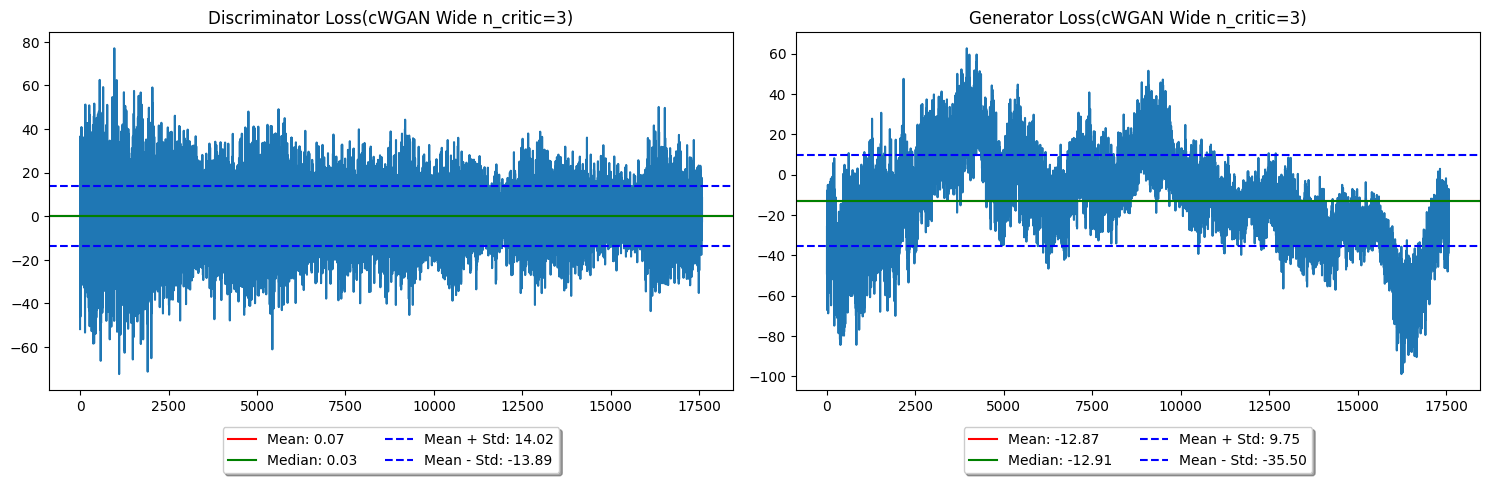

In [ ]:
# further training with n_critic = 3
fp_120 = "wgan/120/mid/120e_3/"

msg = "(cWGAN Wide n_critic=3)"

D_accF, D_accR, D_loss, G_loss, G_acc = further_train_csv(fp_120)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

In [ ]:
# further training with n_critic = 3 with 150e
fp_120 = "wgan/120/mid/150e_3/"

msg = "(cWGAN Wide n_critic=3)"

D_accF, D_accR, D_loss, G_loss, G_acc = further_train_csv(fp_120)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

Mean: 0.7503663985277657. Median: 0.8125. Mean + std = 0.9424466870004435. Mean - std = 0.5582861100550878
Mean: 0.2494023791003434. Median: 0.1875. Mean + std = 0.440898009166812. Mean - std = 0.05790674903387483
Mean: 0.24957549944032328. Median: 0.1875. Mean + std = 0.4414983763633803. Mean - std = 0.0576526225172663


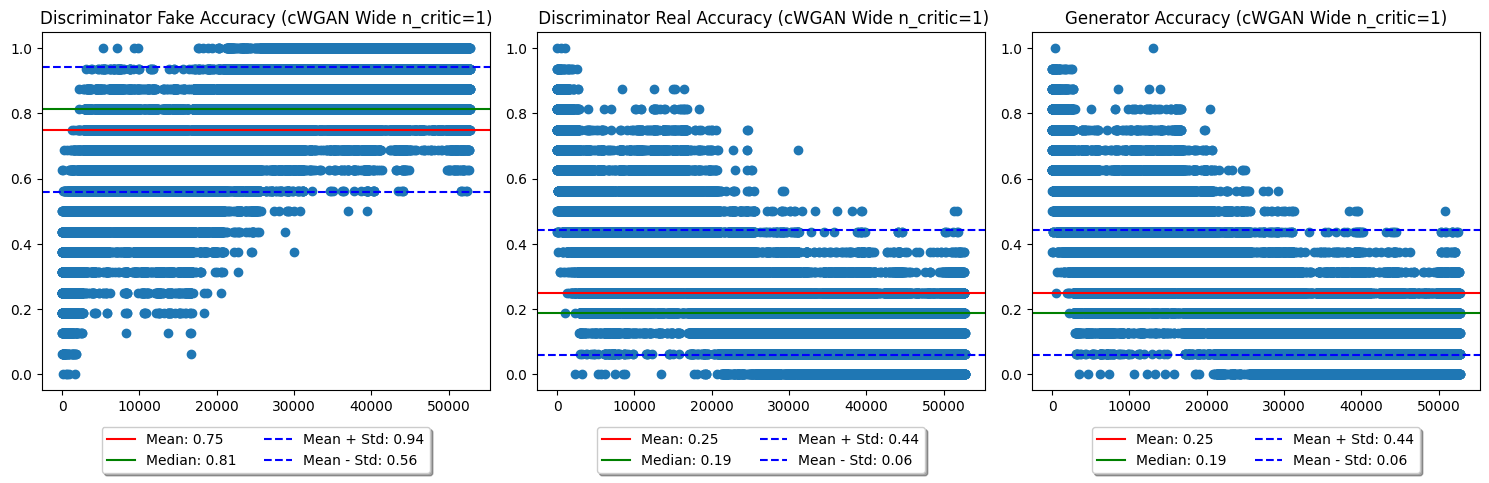

Mean: 0.34377749340719793. Median: 0.3024. Mean + std = 21.683095681518978. Mean - std = -20.99554069470458
Mean: 49.43012416285644. Median: 50.9631. Mean + std = 87.37320014876545. Mean - std = 11.487048176947418


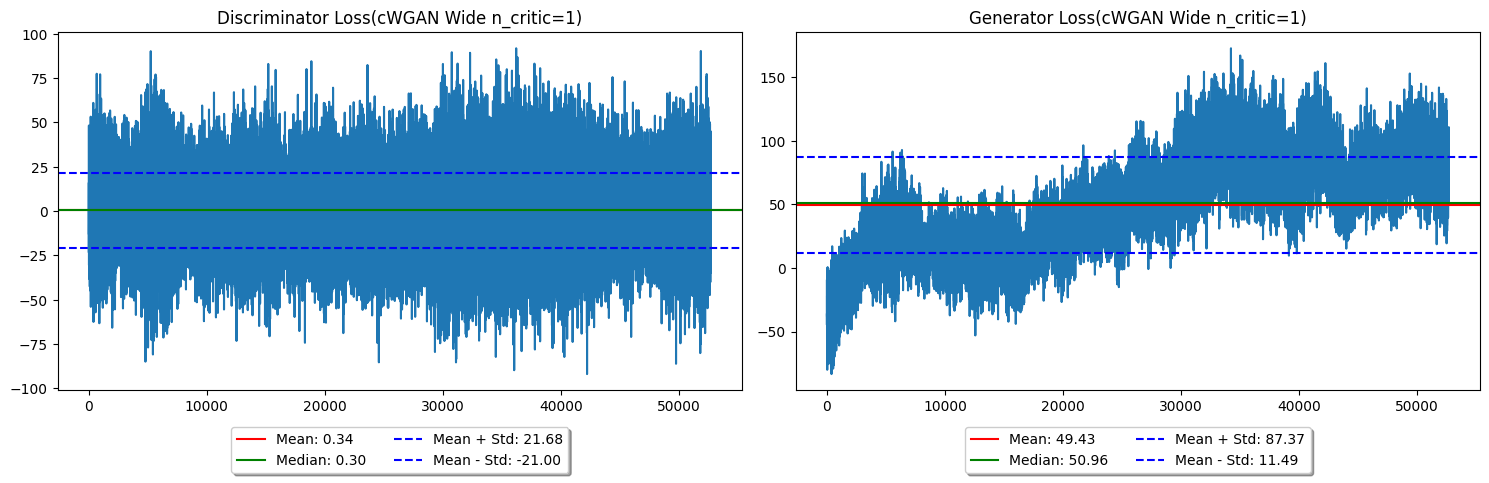

In [ ]:
# further training with n_critic = 1
fp_120 = "wgan/120/mid/120e_1/"

msg = "(cWGAN Wide n_critic=1)"

D_accF, D_accR, D_loss, G_loss, G_acc = further_train_csv(fp_120)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cWGAN Narrow

Mean: 0.5349920475314146. Median: 0.5625. Mean + std = 0.7770252821573274. Mean - std = 0.2929588129055019
Mean: 0.5364366932908359. Median: 0.5625. Mean + std = 0.7881273469646866. Mean - std = 0.28474603961698525
Mean: 0.4624944754869464. Median: 0.4375. Mean + std = 0.704922951499154. Mean - std = 0.22006599947473876


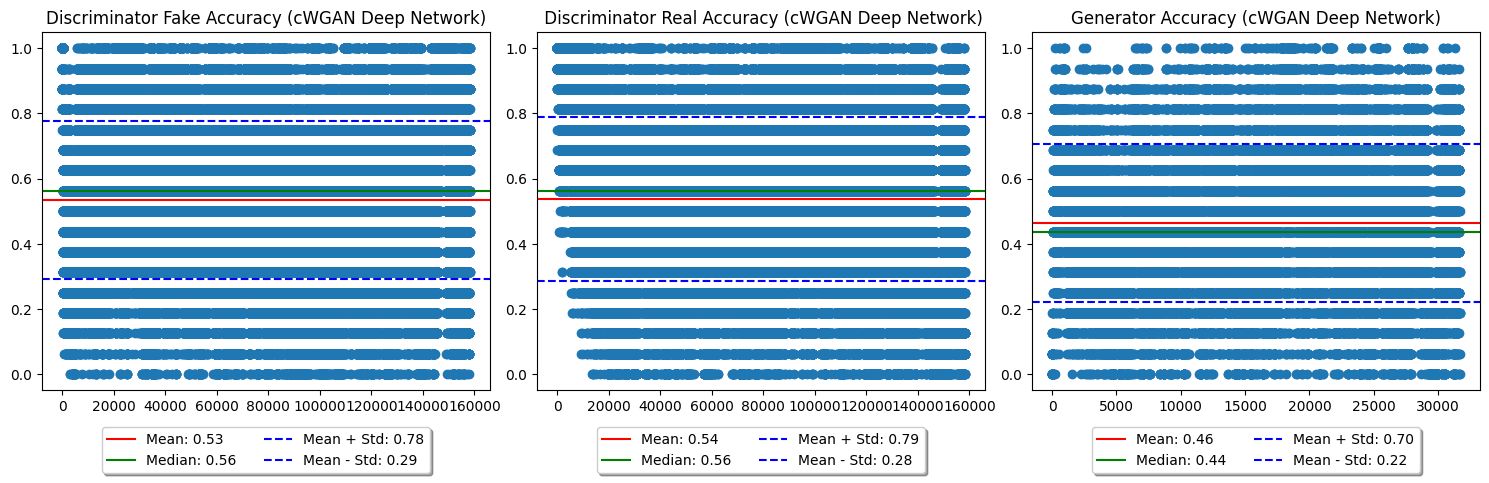

Mean: -4.23000920541718. Median: -4.8385. Mean + std = 22.42684185496137. Mean - std = -30.88686026579573
Mean: 8.486007475455379. Median: 3.3225. Mean + std = 64.10645027757606. Mean - std = -47.134435326665304


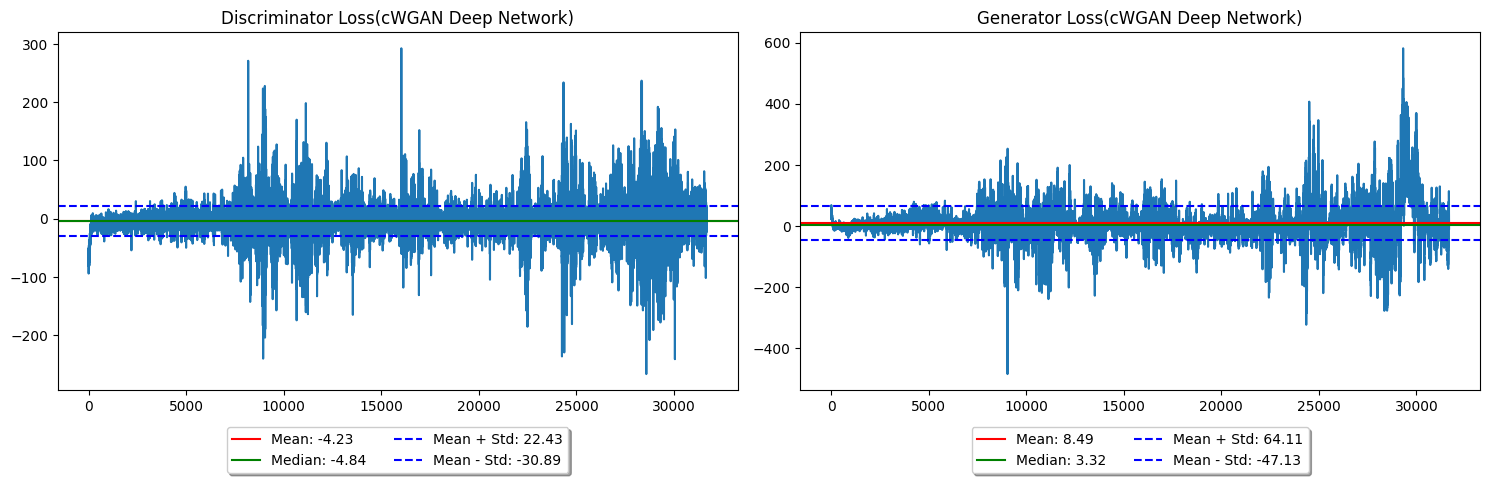

In [ ]:
fp_30 = "wgan/120/deep/30e/"
fp_60 = "wgan/120/deep/60e/"
fp_90 = "wgan/120/deep/90e/"
msg = "(cWGAN Deep Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cWCGAN

Mean: 0.5984390711263731. Median: 0.625. Mean + std = 0.7806955404032301. Mean - std = 0.41618260184951605
Mean: 0.43621464076343697. Median: 0.4375. Mean + std = 0.6224391059615308. Mean - std = 0.2499901755653431
Mean: 0.39701913059948857. Median: 0.375. Mean + std = 0.5772166235693537. Mean - std = 0.21682163762962342


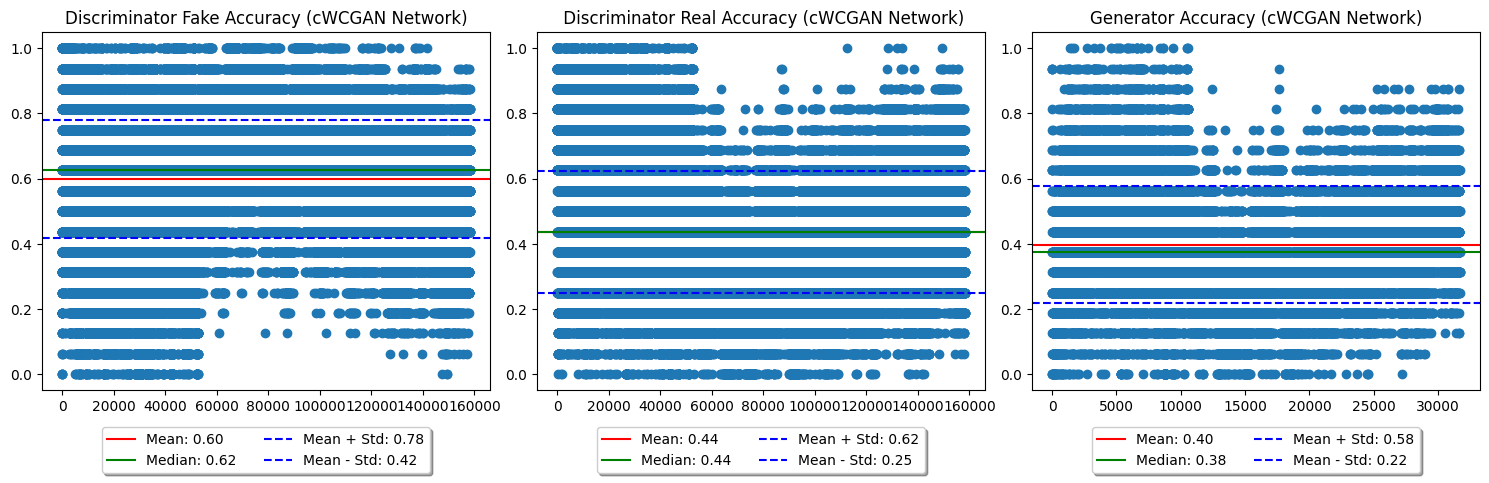

Mean: -2.385446393282192. Median: -2.6279. Mean + std = 27.1687389358118. Mean - std = -31.93963172237618
Mean: 33.61044910818575. Median: 27.8692. Mean + std = 73.90297367662636. Mean - std = -6.682075460254865


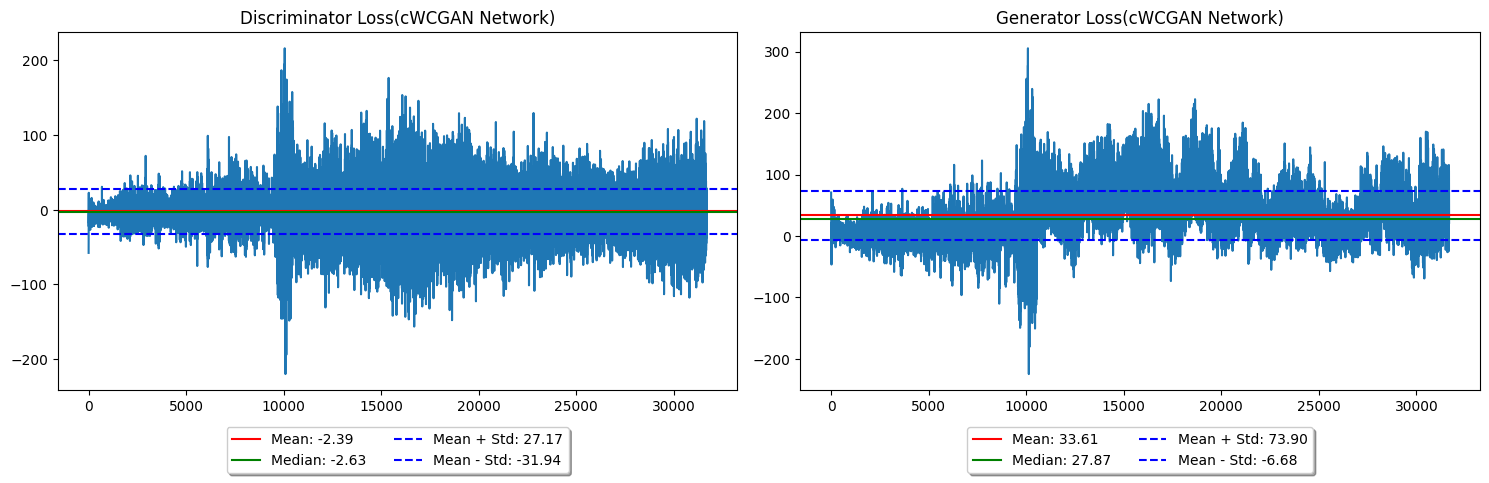

In [ ]:
fp_30 = "cwcgan/30e/"
fp_60 = "cwcgan/60e/"
fp_90 = "cwcgan/90e/"
msg = "(cWCGAN Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)

## cCGAN

Mean: 0.9392242676055192. Median: 1.0. Mean + std = 1.0869455259557077. Mean - std = 0.7915030092553308
Mean: 0.9216070600957825. Median: 0.9375. Mean + std = 1.0321077552151952. Mean - std = 0.8111063649763699
Mean: 0.020162763323456588. Median: 0.0. Mean + std = 0.07243391009206418. Mean - std = -0.032108383445151


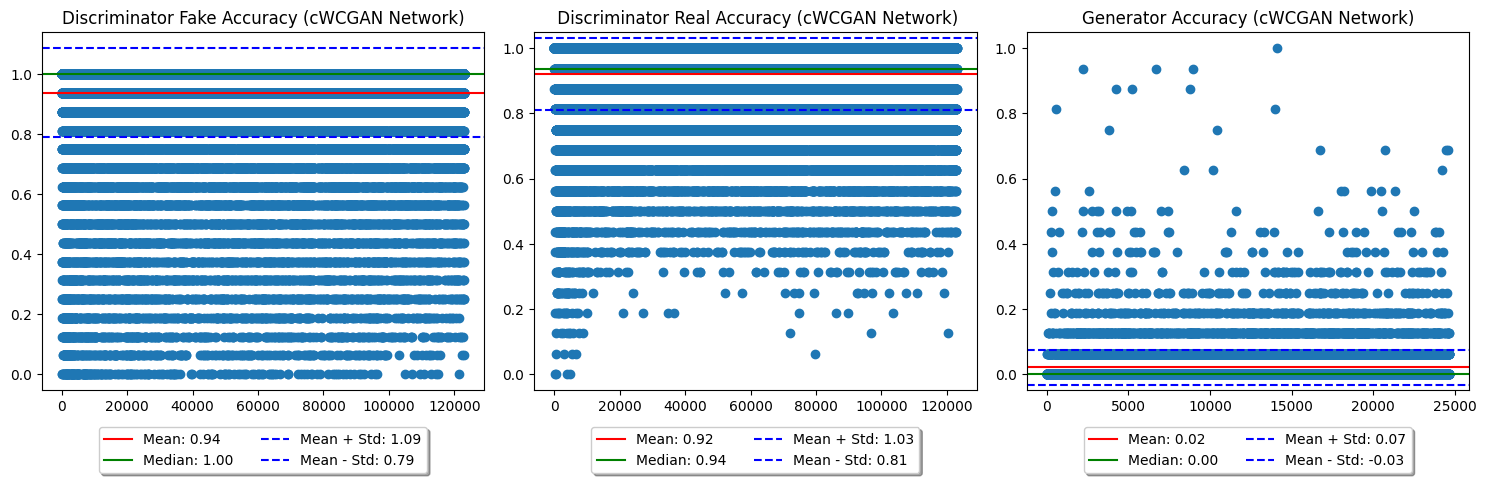

Mean: 0.25865416649754436. Median: 0.1961. Mean + std = 0.5096200479131539. Mean - std = 0.007688285081934809
Mean: 5.74604636522304. Median: 4.7771. Mean + std = 11.083029785329229. Mean - std = 0.40906294511685104


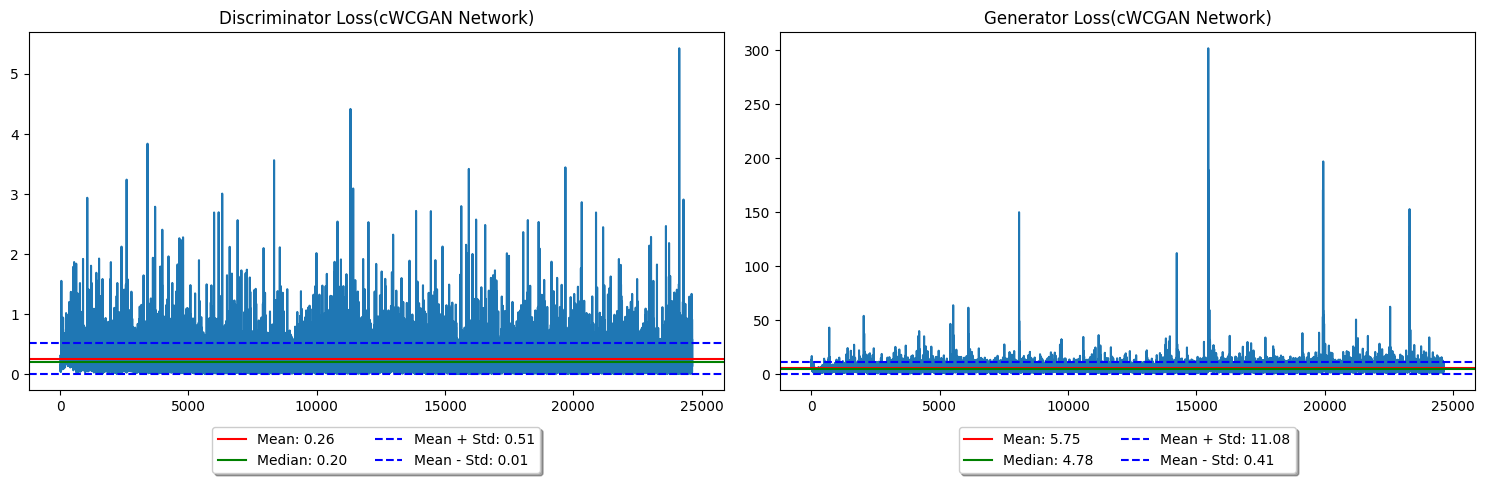

In [ ]:
fp_30 = "ccgan/30e/"
fp_60 = "ccgan/60e/"
fp_90 = "ccgan/90e/"
msg = "(cWCGAN Network)"

D_accF, D_accR, D_loss, G_loss, G_acc = read_result_csv(fp_30, fp_60, fp_90)
plot_acc(D_accF, D_accR , G_acc, msg)
plot_loss(D_loss, G_loss, msg)